In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import random
import librosa.display
from tqdm import tqdm
import gc
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.models import (
    resnet50, ResNet50_Weights,
    efficientnet_b0, EfficientNet_B0_Weights,
    mobilenet_v3_small, MobileNet_V3_Small_Weights,
)

In [ ]:
!pip install --upgrade protobuf==3.20.3


DATA_DIR = "/kaggle/input/fall-audio-detection-dataset" 

audio_files = []

for root, dirs, files in os.walk(DATA_DIR):
    for file in files:
        if file.lower().endswith(".wav"):
            file_path = os.path.join(root, file)

            ff = file.split(".")[0].split("-")[-1]

            label = "Fall" if ff == "01" else "Non-Fall"

            audio_files.append([file, file_path, ff, label])

df = pd.DataFrame(audio_files, columns=["filename", "filepath", "FF_code", "Binary_Label"])

print("Total audio files loaded:", len(df))
df.head()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.3 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tens

,filename,filepath,FF_code,Binary_Label
0,04-246-00-006-02.wav,/kaggle/input/fall-audio-detection-dataset/04-...,02,Non-Fall
1,07-272-00-107-02.wav,/kaggle/input/fall-audio-detection-dataset/07-...,02,Non-Fall
2,07-566-01-048-01.wav,/kaggle/input/fall-audio-detection-dataset/07-...,01,Fall
3,02-520-04-075-01.wav,/kaggle/input/fall-audio-detection-dataset/02-...,01,Fall
4,06-074-00-185-02.wav,/kaggle/input/fall-audio-detection-dataset/06-...,02,Non-Fall


In [3]:
df_falls = df[df["Binary_Label"] == "Fall"].reset_index(drop=True)

print("Number of FALL samples:", len(df_falls))
df_falls.head()


Number of FALL samples: 475


,filename,filepath,FF_code,Binary_Label
0,07-566-01-048-01.wav,/kaggle/input/fall-audio-detection-dataset/07-...,01,Fall
1,02-520-04-075-01.wav,/kaggle/input/fall-audio-detection-dataset/02-...,01,Fall
2,08-233-07-022-01.wav,/kaggle/input/fall-audio-detection-dataset/08-...,01,Fall
3,07-836-05-077-01.wav,/kaggle/input/fall-audio-detection-dataset/07-...,01,Fall
4,04-714-02-113-01.wav,/kaggle/input/fall-audio-detection-dataset/04-...,01,Fall


In [4]:
df_no_falls = df[df["Binary_Label"] == "Non-Fall"].reset_index(drop=True)

print("Number of NON-FALL samples:", len(df_no_falls))
df_no_falls.head()


Number of NON-FALL samples: 475


,filename,filepath,FF_code,Binary_Label
0,04-246-00-006-02.wav,/kaggle/input/fall-audio-detection-dataset/04-...,02,Non-Fall
1,07-272-00-107-02.wav,/kaggle/input/fall-audio-detection-dataset/07-...,02,Non-Fall
2,06-074-00-185-02.wav,/kaggle/input/fall-audio-detection-dataset/06-...,02,Non-Fall
3,01-674-00-388-02.wav,/kaggle/input/fall-audio-detection-dataset/01-...,02,Non-Fall
4,08-341-00-394-02.wav,/kaggle/input/fall-audio-detection-dataset/08-...,02,Non-Fall


In [ ]:
def extract_features(path, sr=16000):
    y, sr = librosa.load(path, sr=sr)

    feats = []

    # 1) MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    feats.extend(np.mean(mfcc, axis=1))
    feats.extend(np.std(mfcc, axis=1))

    # 2) Spectral features
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    roll = librosa.feature.spectral_rolloff(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)

    feats.append(np.mean(cent))
    feats.append(np.std(cent))
    feats.append(np.mean(bw))
    feats.append(np.std(bw))
    feats.append(np.mean(roll))
    feats.append(np.std(roll))

    feats.extend(np.mean(contrast, axis=1))

    # 3) Energy + Sharpness
    rms = librosa.feature.rms(y=y)
    zcr = librosa.feature.zero_crossing_rate(y=y)
    onset_env = librosa.onset.onset_strength(y=y, sr=sr)

    feats.append(np.mean(rms))
    feats.append(np.mean(zcr))
    feats.append(np.mean(onset_env))

    return np.array(feats)


In [6]:
audio_paths = df_falls["filepath"].tolist()   
all_feats = []

for p in audio_paths:
    feats = extract_features(p)
    all_feats.append(feats)

X = np.array(all_feats)
print("Feature shape:", X.shape)


Feature shape: (475, 56)


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
energy_scores = X_scaled[:, -3]  
cluster_energy = [
    np.mean(energy_scores[clusters == 0]),
    np.mean(energy_scores[clusters == 1])
]

high_cluster = np.argmax(cluster_energy)
low_cluster = 1 - high_cluster

labels = ["High" if c == high_cluster else "Low" for c in clusters]


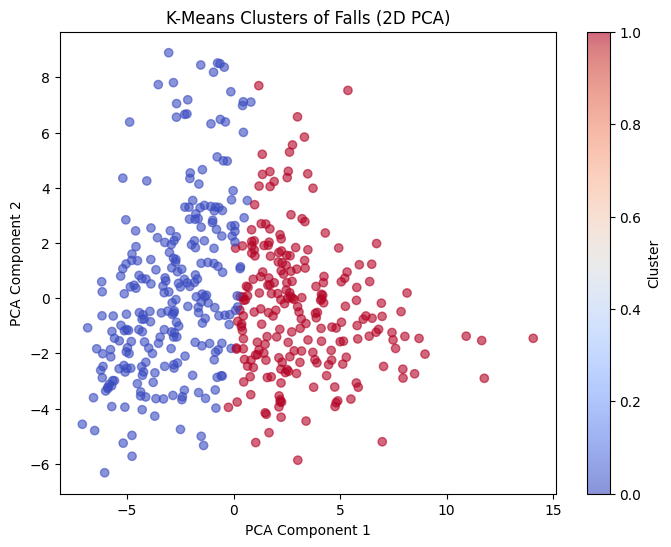

In [ ]:
# Reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
plt.scatter(
    X_pca[:, 0], 
    X_pca[:, 1], 
    c=clusters, 
    cmap="coolwarm", 
    alpha=0.6
)
plt.title("K-Means Clusters of Falls (2D PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, labels, test_size=0.2, random_state=42, stratify=labels
)

In [12]:
clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    random_state=42
)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, n_estimators=300, random_state=42)

In [ ]:
preds = clf.predict(X_test)
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

        High       0.96      0.96      0.96        50
         Low       0.96      0.96      0.96        45

    accuracy                           0.96        95
   macro avg       0.96      0.96      0.96        95
weighted avg       0.96      0.96      0.96        95



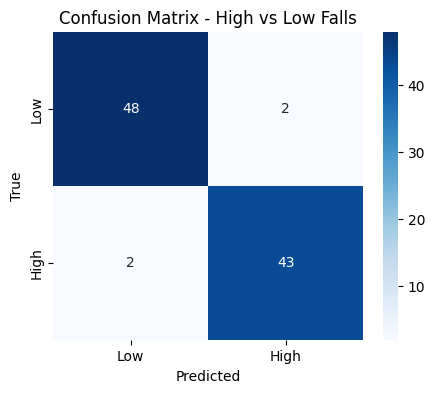

In [ ]:
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low", "High"],
            yticklabels=["Low", "High"])
plt.title("Confusion Matrix - High vs Low Falls")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [ ]:
# 1) Labels from clustering for FALLS
fall_labels = pd.DataFrame({
    "filepath": df_falls["filepath"],
    "label": labels    # High-Fall / Low-Fall
})

# 2) Labels for NON-FALL
no_fall_labels = pd.DataFrame({
    "filepath": df_no_falls["filepath"],
    "label": "No-Fall"
})

df_final = pd.concat([fall_labels, no_fall_labels], axis=0).reset_index(drop=True)

print("Total samples:", len(df_final))
df_final.head()

Total samples: 950


,filepath,label
0,/kaggle/input/fall-audio-detection-dataset/07-...,High
1,/kaggle/input/fall-audio-detection-dataset/02-...,High
2,/kaggle/input/fall-audio-detection-dataset/08-...,High
3,/kaggle/input/fall-audio-detection-dataset/07-...,High
4,/kaggle/input/fall-audio-detection-dataset/04-...,High


In [ ]:
RANDOM_SEED = 42

def stratified_train_test(df, test_size=0.20, label_col="label", seed=RANDOM_SEED):
    df_train, df_test = train_test_split(
        df,
        test_size=test_size,
        stratify=df[label_col],
        random_state=seed
    )
    return df_train.reset_index(drop=True), df_test.reset_index(drop=True)

df_train, df_val = stratified_train_test(df_final, label_col="label")

print("Train set counts:")
print(df_train["label"].value_counts(), "\n")

print("Test set counts:")
print(df_val["label"].value_counts(), "\n")

Train set counts:
label
No-Fall    380
High       201
Low        179
Name: count, dtype: int64 

Test set counts:
label
No-Fall    95
High       50
Low        45
Name: count, dtype: int64 



In [ ]:
# ===========================================
# STEP 1 — Convert Audio to STFT Spectrograms (SAFE dataset style)
# ===========================================

# ==== CONFIG ====
SAMPLE_RATE = 16000
N_FFT = 1024
HOP_LENGTH = 256
IMG_SIZE = (224, 224)
OUTPUT_ROOT = '/content/dataset_spectrograms'
os.makedirs(OUTPUT_ROOT, exist_ok=True)

# ==== Helper: Create spectrogram ====
def save_stft_spectrogram(audio_path, output_path):
    y, _ = librosa.load(audio_path, sr=SAMPLE_RATE, mono=True)
    S = np.abs(librosa.stft(y, n_fft=N_FFT, hop_length=HOP_LENGTH))
    S_db = librosa.amplitude_to_db(S, ref=np.max)

    plt.figure(figsize=(2.24, 2.24), dpi=100)
    librosa.display.specshow(S_db, sr=SAMPLE_RATE, hop_length=HOP_LENGTH,
                             x_axis=None, y_axis=None, cmap='gray_r')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.close()

# ==== Process and Save Splits ====
def save_split(df_split, split_name):
    for cls in df_split["label"].unique():
        os.makedirs(os.path.join(OUTPUT_ROOT, split_name, cls), exist_ok=True)

    for _, row in tqdm(df_split.iterrows(), total=len(df_split), desc=f"Processing {split_name}"):
        audio_path = row["filepath"]
        cls = row["label"]
        filename = os.path.splitext(os.path.basename(audio_path))[0] + ".png"
        output_path = os.path.join(OUTPUT_ROOT, split_name, cls, filename)
        save_stft_spectrogram(audio_path, output_path)

# Assuming you already have df_train and df_val from your previous split
save_split(df_train, 'train')
save_split(df_val, 'val')

print("✅ STFT Spectrograms ready under:", OUTPUT_ROOT)

Processing val: 100%|██████████| 190/190 [00:28<00:00,  6.67it/s]

✅ STFT Spectrograms ready under: /content/dataset_spectrograms


Classes: ['High', 'Low', 'No-Fall']


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:00<00:00, 208MB/s] 
/tmp/ipykernel_47/777431791.py:81: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(AMP and DEVICE=='cuda'))
/tmp/ipykernel_47/777431791.py:98: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(AMP and DEVICE=='cuda')):
/tmp/ipykernel_47/777431791.py:119: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(AMP and DEVICE=='cuda')):


Epoch 01/20 | Train Acc=0.571 | Val Acc=0.705
Epoch 02/20 | Train Acc=0.786 | Val Acc=0.811
Epoch 03/20 | Train Acc=0.847 | Val Acc=0.789
Epoch 04/20 | Train Acc=0.872 | Val Acc=0.811
Epoch 05/20 | Train Acc=0.896 | Val Acc=0.874
Epoch 06/20 | Train Acc=0.921 | Val Acc=0.905
Epoch 07/20 | Train Acc=0.921 | Val Acc=0.916
Epoch 08/20 | Train Acc=0.924 | Val Acc=0.895
Epoch 09/20 | Train Acc=0.949 | Val Acc=0.911
Epoch 10/20 | Train Acc=0.945 | Val Acc=0.826
Epoch 11/20 | Train Acc=0.928 | Val Acc=0.921
Epoch 12/20 | Train Acc=0.966 | Val Acc=0.911
Epoch 13/20 | Train Acc=0.959 | Val Acc=0.926
Epoch 14/20 | Train Acc=0.971 | Val Acc=0.895
Epoch 15/20 | Train Acc=0.955 | Val Acc=0.926
Epoch 16/20 | Train Acc=0.963 | Val Acc=0.895
Epoch 17/20 | Train Acc=0.959 | Val Acc=0.926
Epoch 18/20 | Train Acc=0.959 | Val Acc=0.879
Epoch 19/20 | Train Acc=0.976 | Val Acc=0.932
Epoch 20/20 | Train Acc=0.971 | Val Acc=0.884
✅ Training complete! Best val acc: 0.9315789473684211


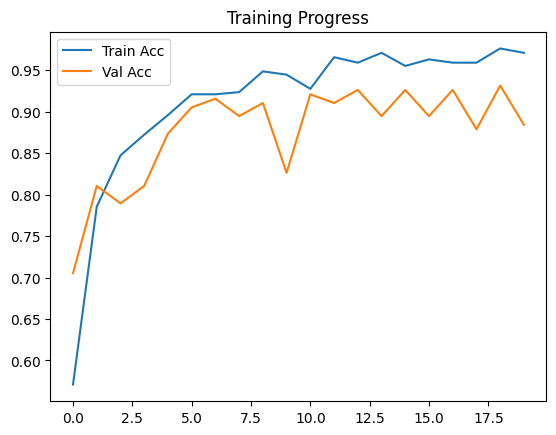


✅ Quick Validation Accuracy on 5 batches = 0.9000


/tmp/ipykernel_47/777431791.py:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(AMP and DEVICE=='cuda')):


In [ ]:
# ===========================================
# STEP 2 — Train ConvNeXt on SAFE Spectrograms (Optimized & Stable on Colab)
# ===========================================

# ---------- Config ----------
DATA_ROOT = '/content/dataset_spectrograms'
DEVICE    = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS    = 20
BATCH_SIZE= 4         
LR        = 1e-4
WD        = 1e-4
AMP       = True        # Mixed precision

torch.backends.cudnn.benchmark = True

# ---------- Transforms ----------
train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

val_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
])

# ---------- Datasets / Loaders ----------
train_ds = datasets.ImageFolder(os.path.join(DATA_ROOT, 'train'), transform=train_tf)
val_ds   = datasets.ImageFolder(os.path.join(DATA_ROOT, 'val'),   transform=val_tf)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                      num_workers=0, pin_memory=False)
val_dl   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,
                      num_workers=0, pin_memory=False)

CLASSES = train_ds.classes
print("Classes:", CLASSES)

# ---------- Model ----------
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights
weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1
model = convnext_tiny(weights=weights)

old_conv = model.features[0][0]  # Conv2d(3, 96, k=4, s=4)
new_conv = nn.Conv2d(1, old_conv.out_channels, kernel_size=old_conv.kernel_size,
                     stride=old_conv.stride, padding=old_conv.padding, bias=old_conv.bias is not None)

with torch.no_grad():
    new_conv.weight.copy_(old_conv.weight.mean(dim=1, keepdim=True))
    if old_conv.bias is not None:
        new_conv.bias.copy_(old_conv.bias)

model.features[0][0] = new_conv

in_feats = model.classifier[2].in_features
model.classifier[2] = nn.Linear(in_feats, len(CLASSES))

model = model.to(DEVICE)

# ---------- Optim / Loss / AMP ----------
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WD)
scaler = torch.cuda.amp.GradScaler(enabled=(AMP and DEVICE=='cuda'))

# ---------- Train ----------
best_acc = 0.0
train_hist, val_hist = [], []

for epoch in range(1, EPOCHS+1):
    gc.collect(); 
    if torch.cuda.is_available(): torch.cuda.empty_cache()

    # --- train ---
    model.train()
    total, correct, loss_sum = 0, 0, 0.0
    for xb, yb in train_dl:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        optimizer.zero_grad(set_to_none=True)

        with torch.cuda.amp.autocast(enabled=(AMP and DEVICE=='cuda')):
            logits = model(xb)
            loss = criterion(logits, yb)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loss_sum += loss.item() * xb.size(0)
        correct  += (logits.argmax(1) == yb).sum().item()
        total    += yb.size(0)

    train_acc = correct / total
    train_hist.append(train_acc)

    # --- validate ---
    model.eval()
    v_total, v_correct = 0, 0
    with torch.no_grad():
        for xb, yb in val_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            with torch.cuda.amp.autocast(enabled=(AMP and DEVICE=='cuda')):
                out = model(xb)
            v_correct += (out.argmax(1) == yb).sum().item()
            v_total   += yb.size(0)

    val_acc = v_correct / v_total
    val_hist.append(val_acc)
    print(f"Epoch {epoch:02d}/{EPOCHS} | Train Acc={train_acc:.3f} | Val Acc={val_acc:.3f}")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_safe_model.pth')

print("✅ Training complete! Best val acc:", best_acc)

# ---------- Curves ----------
plt.plot(train_hist, label='Train Acc')
plt.plot(val_hist, label='Val Acc')
plt.legend(); plt.title("Training Progress"); plt.show()

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

model.load_state_dict(torch.load('best_safe_model.pth', map_location=DEVICE))
model.eval()

total, correct = 0, 0
batch_count = 0

with torch.no_grad():
    for i, (xb, yb) in enumerate(val_dl):
        if i >= 5:
            break
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        with torch.cuda.amp.autocast(enabled=(AMP and DEVICE=='cuda')):
            out = model(xb)
        preds = out.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
        batch_count += 1

acc = correct / total if total > 0 else 0
print(f"\n✅ Quick Validation Accuracy on {batch_count} batches = {acc:.4f}")

/tmp/ipykernel_47/1111774719.py:21: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(AMP and DEVICE=='cuda')):



📊 Classification Report:

              precision    recall  f1-score   support

        High     0.8491    0.9000    0.8738        50
         Low     0.9268    0.8444    0.8837        45
     No-Fall     0.9792    0.9895    0.9843        95

    accuracy                         0.9316       190
   macro avg     0.9184    0.9113    0.9139       190
weighted avg     0.9325    0.9316    0.9314       190



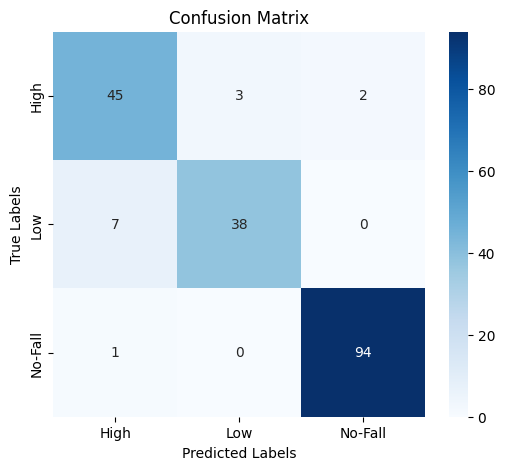

In [ ]:
# ====================================================
# Full Evaluation on Validation (Safe Memory Version)
# ====================================================

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

model.load_state_dict(torch.load('best_safe_model.pth', map_location=DEVICE))
model.eval()

ys, ps = [], []

with torch.no_grad():
    for xb, yb in val_dl:
        xb = xb.to(DEVICE)
        with torch.cuda.amp.autocast(enabled=(AMP and DEVICE=='cuda')):
            out = model(xb)
        ys += yb.tolist()
        ps += out.argmax(1).cpu().tolist()

# === Classification Report ===
print("\n Classification Report:\n")
print(classification_report(ys, ps, target_names=CLASSES, digits=4))

# === Confusion Matrix ===
cm = confusion_matrix(ys, ps)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# =====================================================
# BLOCK 1 — Model factory for trying different backbones
# Uses the SAME pipeline & dataloaders (train_dl, val_dl)
# =====================================================

def create_backbone(model_name: str, num_classes: int):
    """
    model_name: 'resnet50', 'efficientnet_b0', 'mobilenet_v3_small'
    All are adapted to 1-channel input (grayscale STFT) and 3 classes.
    """
    if model_name == "resnet50":
        weights = ResNet50_Weights.IMAGENET1K_V1
        model = resnet50(weights=weights)

        # Adapt first conv: 3→1 channel, keep pretrained info (mean over RGB)
        old_conv = model.conv1
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=(old_conv.bias is not None),
        )
        with torch.no_grad():
            new_conv.weight.copy_(old_conv.weight.mean(dim=1, keepdim=True))
            if old_conv.bias is not None:
                new_conv.bias.copy_(old_conv.bias)
        model.conv1 = new_conv

        in_feats = model.fc.in_features
        model.fc = nn.Linear(in_feats, num_classes)

    elif model_name == "efficientnet_b0":
        weights = EfficientNet_B0_Weights.IMAGENET1K_V1
        model = efficientnet_b0(weights=weights)

        # First conv is in features[0][0]
        old_conv = model.features[0][0]
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=(old_conv.bias is not None),
        )
        with torch.no_grad():
            new_conv.weight.copy_(old_conv.weight.mean(dim=1, keepdim=True))
            if old_conv.bias is not None:
                new_conv.bias.copy_(old_conv.bias)
        model.features[0][0] = new_conv

        in_feats = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_feats, num_classes)

    elif model_name == "mobilenet_v3_small":
        weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
        model = mobilenet_v3_small(weights=weights)

        # First conv = model.features[0][0]
        old_conv = model.features[0][0]
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=old_conv.out_channels,
            kernel_size=old_conv.kernel_size,
            stride=old_conv.stride,
            padding=old_conv.padding,
            bias=(old_conv.bias is not None),
        )
        with torch.no_grad():
            new_conv.weight.copy_(old_conv.weight.mean(dim=1, keepdim=True))
            if old_conv.bias is not None:
                new_conv.bias.copy_(old_conv.bias)
        model.features[0][0] = new_conv

        in_feats = model.classifier[3].in_features  # final linear
        model.classifier[3] = nn.Linear(in_feats, num_classes)

    else:
        raise ValueError(f"Unknown model_name: {model_name}")

    return model.to(DEVICE)

In [ ]:
# =====================================================
# BLOCK 2 — Shared training & evaluation for experiments
# =====================================================

def train_backbone(model_name: str,
                   epochs: int = EPOCHS,
                   lr: float = LR,
                   wd: float = WD,
                   use_amp: bool = AMP):
    """
    Trains a single backbone with the SAME pipeline:
    - STFT spectrograms
    - grayscale transforms
    - BATCH_SIZE, LR, WD, EPOCHS as in ConvNeXt run
    """
    model = create_backbone(model_name, num_classes=len(CLASSES))

    criterion = nn.CrossEntropyLoss()
    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=wd)
    scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE == "cuda"))

    best_acc = 0.0
    train_hist, val_hist = [], []
    ckpt_path = f"best_{model_name}_stft_kmeans.pth"

    for epoch in range(1, epochs + 1):
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # ----- train -----
        model.train()
        total, correct = 0, 0

        for xb, yb in train_dl:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad(set_to_none=True)

            with torch.cuda.amp.autocast(enabled=(use_amp and DEVICE == "cuda")):
                logits = model(xb)
                loss = criterion(logits, yb)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            preds = logits.argmax(1)
            correct += (preds == yb).sum().item()
            total   += yb.size(0)

        train_acc = correct / total
        train_hist.append(train_acc)

        # ----- validate -----
        model.eval()
        v_total, v_correct = 0, 0
        with torch.no_grad():
            for xb, yb in val_dl:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                with torch.cuda.amp.autocast(enabled=(use_amp and DEVICE == "cuda")):
                    out = model(xb)
                preds = out.argmax(1)
                v_correct += (preds == yb).sum().item()
                v_total   += yb.size(0)

        val_acc = v_correct / v_total
        val_hist.append(val_acc)

        print(f"[{model_name}] Epoch {epoch:02d}/{epochs} "
              f"| Train Acc={train_acc:.3f} | Val Acc={val_acc:.3f}")

        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), ckpt_path)

    print(f"✅ {model_name} done. Best val acc = {best_acc:.4f}")
    return model, train_hist, val_hist, best_acc, ckpt_path


def plot_curves(train_hist, val_hist, title="Training"):
    plt.figure(figsize=(6,4))
    plt.plot(train_hist, label="Train Acc")
    plt.plot(val_hist,   label="Val Acc")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.title(title); plt.grid(True); plt.legend()
    plt.show()


def evaluate_backbone(model_name: str, ckpt_path: str, title_suffix: str = ""):
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

    model = create_backbone(model_name, num_classes=len(CLASSES))
    model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
    model.eval()

    ys, ps = [], []
    with torch.no_grad():
        for xb, yb in val_dl:
            xb = xb.to(DEVICE)
            with torch.cuda.amp.autocast(enabled=(AMP and DEVICE == "cuda")):
                out = model(xb)
            ys += yb.tolist()
            ps += out.argmax(1).cpu().tolist()

    print("\n📊 Classification report:\n")
    print(classification_report(ys, ps, target_names=CLASSES, digits=4))

    cm = confusion_matrix(ys, ps)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=CLASSES, yticklabels=CLASSES)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix – {model_name} {title_suffix}")
    plt.show()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 204MB/s]
/tmp/ipykernel_47/800077809.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE == "cuda"))
/tmp/ipykernel_47/800077809.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and DEVICE == "cuda")):
/tmp/ipykernel_47/800077809.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and DEVICE == "cuda")):


[resnet50] Epoch 01/20 | Train Acc=0.614 | Val Acc=0.826
[resnet50] Epoch 02/20 | Train Acc=0.770 | Val Acc=0.842
[resnet50] Epoch 03/20 | Train Acc=0.837 | Val Acc=0.916
[resnet50] Epoch 04/20 | Train Acc=0.862 | Val Acc=0.879
[resnet50] Epoch 05/20 | Train Acc=0.876 | Val Acc=0.863
[resnet50] Epoch 06/20 | Train Acc=0.887 | Val Acc=0.884
[resnet50] Epoch 07/20 | Train Acc=0.887 | Val Acc=0.937
[resnet50] Epoch 08/20 | Train Acc=0.900 | Val Acc=0.905
[resnet50] Epoch 09/20 | Train Acc=0.899 | Val Acc=0.905
[resnet50] Epoch 10/20 | Train Acc=0.928 | Val Acc=0.879
[resnet50] Epoch 11/20 | Train Acc=0.922 | Val Acc=0.700
[resnet50] Epoch 12/20 | Train Acc=0.922 | Val Acc=0.921
[resnet50] Epoch 13/20 | Train Acc=0.946 | Val Acc=0.916
[resnet50] Epoch 14/20 | Train Acc=0.928 | Val Acc=0.847
[resnet50] Epoch 15/20 | Train Acc=0.942 | Val Acc=0.937
[resnet50] Epoch 16/20 | Train Acc=0.916 | Val Acc=0.900
[resnet50] Epoch 17/20 | Train Acc=0.934 | Val Acc=0.921
[resnet50] Epoch 18/20 | Train 

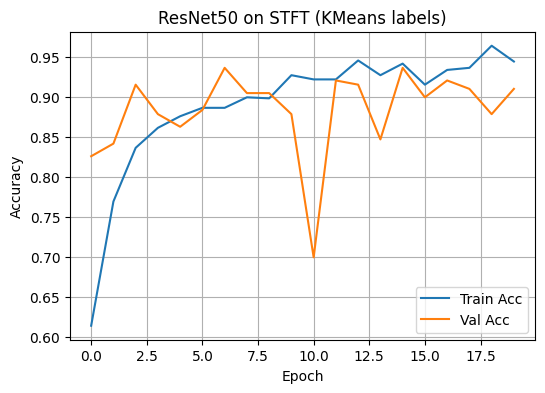

/tmp/ipykernel_47/800077809.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(AMP and DEVICE == "cuda")):



📊 Classification report:

              precision    recall  f1-score   support

        High     0.9556    0.8600    0.9053        50
         Low     0.8889    0.8889    0.8889        45
     No-Fall     0.9500    1.0000    0.9744        95

    accuracy                         0.9368       190
   macro avg     0.9315    0.9163    0.9228       190
weighted avg     0.9370    0.9368    0.9359       190



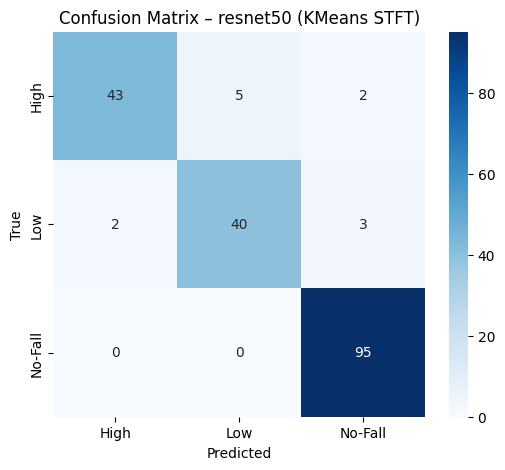

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 144MB/s]
/tmp/ipykernel_47/800077809.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE == "cuda"))
/tmp/ipykernel_47/800077809.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and DEVICE == "cuda")):
/tmp/ipykernel_47/800077809.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and DEVICE == "cuda")):


[efficientnet_b0] Epoch 01/20 | Train Acc=0.593 | Val Acc=0.753
[efficientnet_b0] Epoch 02/20 | Train Acc=0.754 | Val Acc=0.847
[efficientnet_b0] Epoch 03/20 | Train Acc=0.820 | Val Acc=0.895
[efficientnet_b0] Epoch 04/20 | Train Acc=0.842 | Val Acc=0.911
[efficientnet_b0] Epoch 05/20 | Train Acc=0.878 | Val Acc=0.868
[efficientnet_b0] Epoch 06/20 | Train Acc=0.892 | Val Acc=0.900
[efficientnet_b0] Epoch 07/20 | Train Acc=0.901 | Val Acc=0.900
[efficientnet_b0] Epoch 08/20 | Train Acc=0.922 | Val Acc=0.911
[efficientnet_b0] Epoch 09/20 | Train Acc=0.925 | Val Acc=0.921
[efficientnet_b0] Epoch 10/20 | Train Acc=0.934 | Val Acc=0.932
[efficientnet_b0] Epoch 11/20 | Train Acc=0.937 | Val Acc=0.884
[efficientnet_b0] Epoch 12/20 | Train Acc=0.954 | Val Acc=0.868
[efficientnet_b0] Epoch 13/20 | Train Acc=0.961 | Val Acc=0.905
[efficientnet_b0] Epoch 14/20 | Train Acc=0.947 | Val Acc=0.889
[efficientnet_b0] Epoch 15/20 | Train Acc=0.950 | Val Acc=0.889
[efficientnet_b0] Epoch 16/20 | Train Ac

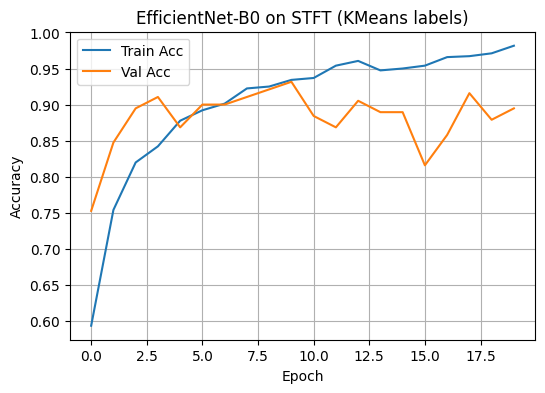

/tmp/ipykernel_47/800077809.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(AMP and DEVICE == "cuda")):



📊 Classification report:

              precision    recall  f1-score   support

        High     0.9302    0.8000    0.8602        50
         Low     0.8600    0.9556    0.9053        45
     No-Fall     0.9691    0.9895    0.9792        95

    accuracy                         0.9316       190
   macro avg     0.9198    0.9150    0.9149       190
weighted avg     0.9330    0.9316    0.9304       190



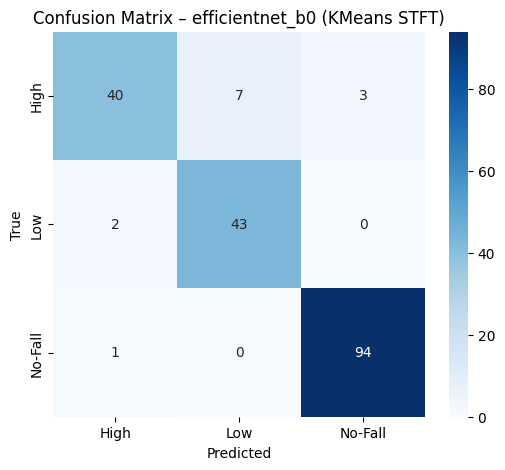

Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 106MB/s]
/tmp/ipykernel_47/800077809.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(use_amp and DEVICE == "cuda"))
/tmp/ipykernel_47/800077809.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and DEVICE == "cuda")):
/tmp/ipykernel_47/800077809.py:64: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(use_amp and DEVICE == "cuda")):


[mobilenet_v3_small] Epoch 01/20 | Train Acc=0.596 | Val Acc=0.500
[mobilenet_v3_small] Epoch 02/20 | Train Acc=0.736 | Val Acc=0.500
[mobilenet_v3_small] Epoch 03/20 | Train Acc=0.820 | Val Acc=0.500
[mobilenet_v3_small] Epoch 04/20 | Train Acc=0.817 | Val Acc=0.795
[mobilenet_v3_small] Epoch 05/20 | Train Acc=0.847 | Val Acc=0.884
[mobilenet_v3_small] Epoch 06/20 | Train Acc=0.847 | Val Acc=0.826
[mobilenet_v3_small] Epoch 07/20 | Train Acc=0.871 | Val Acc=0.863
[mobilenet_v3_small] Epoch 08/20 | Train Acc=0.878 | Val Acc=0.853
[mobilenet_v3_small] Epoch 09/20 | Train Acc=0.867 | Val Acc=0.895
[mobilenet_v3_small] Epoch 10/20 | Train Acc=0.914 | Val Acc=0.905
[mobilenet_v3_small] Epoch 11/20 | Train Acc=0.913 | Val Acc=0.884
[mobilenet_v3_small] Epoch 12/20 | Train Acc=0.903 | Val Acc=0.863
[mobilenet_v3_small] Epoch 13/20 | Train Acc=0.932 | Val Acc=0.889
[mobilenet_v3_small] Epoch 14/20 | Train Acc=0.909 | Val Acc=0.926
[mobilenet_v3_small] Epoch 15/20 | Train Acc=0.916 | Val Acc=0

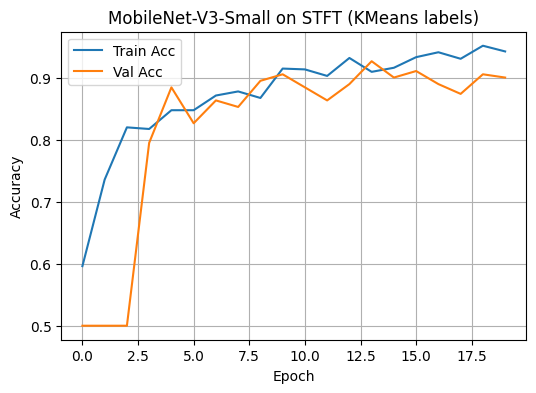

/tmp/ipykernel_47/800077809.py:106: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(AMP and DEVICE == "cuda")):



📊 Classification report:

              precision    recall  f1-score   support

        High     0.8913    0.8200    0.8542        50
         Low     0.8542    0.9111    0.8817        45
     No-Fall     0.9792    0.9895    0.9843        95

    accuracy                         0.9263       190
   macro avg     0.9082    0.9069    0.9067       190
weighted avg     0.9264    0.9263    0.9258       190



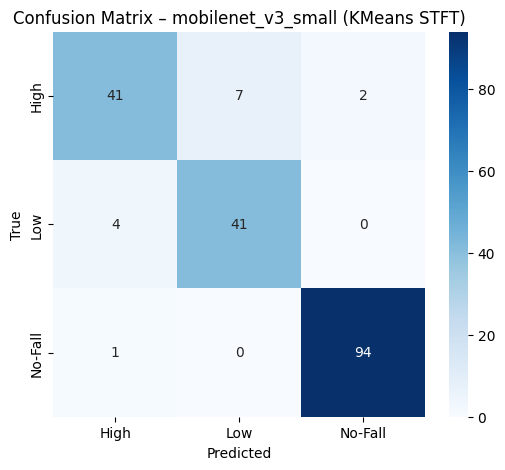

In [22]:
# =====================================================
# BLOCK 3 — Run different models with SAME pipeline
# =====================================================

# --- EXP1: ResNet50 ---
model_res, tr_res, va_res, best_res, ckpt_res = train_backbone("resnet50")
plot_curves(tr_res, va_res, title="ResNet50 on STFT (KMeans labels)")
evaluate_backbone("resnet50", ckpt_res, title_suffix="(KMeans STFT)")

# --- EXP2: EfficientNet-B0 ---
model_eff, tr_eff, va_eff, best_eff, ckpt_eff = train_backbone("efficientnet_b0")
plot_curves(tr_eff, va_eff, title="EfficientNet-B0 on STFT (KMeans labels)")
evaluate_backbone("efficientnet_b0", ckpt_eff, title_suffix="(KMeans STFT)")

# --- EXP3: MobileNet-V3-Small (good candidate for deployment) ---
model_mob, tr_mob, va_mob, best_mob, ckpt_mob = train_backbone("mobilenet_v3_small")
plot_curves(tr_mob, va_mob, title="MobileNet-V3-Small on STFT (KMeans labels)")
evaluate_backbone("mobilenet_v3_small", ckpt_mob, title_suffix="(KMeans STFT)")


In [ ]:
SAVE_PATH = "fall_convnext_tiny_state_dict.pth"

checkpoint = {
    "model_state_dict": model.state_dict(),
    "classes": CLASSES,
}

torch.save(checkpoint, SAVE_PATH)
print("Saved to", SAVE_PATH)
